# Spam Filter: Text Classification with uci Enron dataset
#### スパムメールフィルター 2019-01-05

![title](https://cdn-images-1.medium.com/max/1600/1*q9dcSnDS6kcU9hGHM1iY_A.png)

## 1. Inspecting the dataset データの調査

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
import os

In [6]:
os.chdir("/Users/akr712/Desktop/PUSH LIST/80% done")
df = pd.read_table("SMSSpamCollection.txt", header=None)
df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


データの詳細を一通り眺める

In [7]:
df.shape

(5572, 2)

In [8]:
df.columns = ["Target", "Text"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
Target    5572 non-null object
Text      5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


【メモ】
  「スパム」のデータ量は、「スパムではないメッセージ」のデータ量に比べてかなり少ない。

In [9]:
df["Target"].value_counts()

ham     4825
spam     747
Name: Target, dtype: int64

「スパム」と「スパムではないメッセージ」によく含まれる単語の違いをイメージできるようにする。

計算負荷を減らすため、目的変数となる"Target"列をバイナリに変換する

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
le = LabelEncoder()
y = le.fit_transform(df["Target"])

In [13]:
y[:5]

array([0, 0, 1, 0, 0])

## 2. Text preprocessing - 前処理 - 

自然言語を特徴量に転換するために、数値情報に変える必要がある。   
自然言語処理では、元データとなる文章や単語をそのまま特徴量として使おうとすると、以下のデメリットが生じる。   
    
・説明変数が膨大になり学習に時間がかかる  
・過学習を起こしやすくなる    

### 2-1. Normalization - 単語の正規化 -    
    
大文字や小文字を揃える

![text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTp7ERA8pYIVb6Afzvihd0G75GIPX4q5nAJMw3fZBaFK19IihnnBw)

In [14]:
text_exapmple = df.iloc[0]["Text"]
text_exapmple

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

まず、本文とは関係がない文字列や頻出する記号や単語を排除する。  
「メールアドレス」、「URL」、「$」、「電話番号」など。

In [15]:
raw_text = df["Text"]
processed = raw_text.str.replace(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b',
                                 'emailaddr')
processed = processed.str.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)',
                                  'httpaddr')
processed = processed.str.replace(r'£|\$', 'moneysymb')    
processed = processed.str.replace(
    r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
    'phonenumbr')    
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

In [16]:
# "today"と"today?"を揃える
processed = processed.str.replace(r'[^\w\d\s]', ' ')
processed = processed.str.replace(r'\s+', ' ')
processed = processed.str.replace(r'^\s+|\s+?$', '')

In [17]:
# 全て小文字にする
processed = processed.str.lower()

### 2-2. Stop words - ストップワードの削除 -

頻出するものの、文章の特徴を表す訳ではない単語をストップワードとして、特徴から外してしまう。   
例としては、"when"や"had"などが含まれる。   
基本的にはコーパスと呼ばれる各言語ごとの文脈を含んだ辞書にストップワードリストがまとめられている。   

In [18]:
stop_words = nltk.corpus.stopwords.words('english')
processed = processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in set(stop_words)))

### 2-3. Stemming - 語幹による単語の統一化 -  
    

語形の変化を取り除き、同一の単語表現に変換する処理のこと。   
例えば、「run」というクエリで検索をした場合でもrunnerやrunningなどのキーワードとマッチングさせること。

In [19]:
porter = nltk.PorterStemmer()
processed = processed.apply(lambda x: " ".join(porter.stem(term) for term in x.split()))

In [24]:
processed[:10]

0    go jurong point crazi avail bugi n great world...
1                                ok lar joke wif u oni
2    free entri numbr wkli comp win fa cup final tk...
3                  u dun say earli hor u c alreadi say
4                 nah think goe usf live around though
5    freemsg hey darl numbr week word back like fun...
6        even brother like speak treat like aid patent
7    per request mell mell oru minnaminungint nurun...
8    winner valu network custom select receivea mon...
9    mobil numbr month u r entitl updat latest colo...
Name: Text, dtype: object

In [25]:
def preprocess_text(messy_string):
    assert(type(messy_string) == str)
    cleaned = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', messy_string)
    cleaned = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr',
                     cleaned)
    cleaned = re.sub(r'£|\$', 'moneysymb', cleaned)
    cleaned = re.sub(
        r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
        'phonenumbr', cleaned)
    cleaned = re.sub(r'\d+(\.\d+)?', 'numbr', cleaned)
    cleaned = re.sub(r'[^\w\d\s]', ' ', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = re.sub(r'^\s+|\s+?$', '', cleaned.lower())
    return ' '.join(
        porter.stem(term) 
        for term in cleaned.split()
        if term not in set(stop_words)
    )

## 3. Feature engineering - 特徴量生成 -

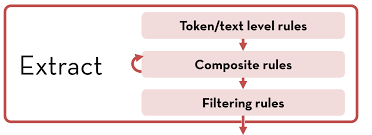

### 3-1. Tokenization - トークン化（単語分解） -

In [27]:
seqquences = []
for text in processed:
    ntext = preprocess_text(text)
    seqquence = ntext.split()
    seqquences.append(seqquence)

In [28]:
seqquences[:10]

[['go',
  'jurong',
  'point',
  'crazi',
  'avail',
  'bugi',
  'n',
  'great',
  'world',
  'la',
  'e',
  'buffet',
  'cine',
  'got',
  'amor',
  'wat'],
 ['ok', 'lar', 'joke', 'wif', 'u', 'oni'],
 ['free',
  'entri',
  'numbr',
  'wkli',
  'comp',
  'win',
  'fa',
  'cup',
  'final',
  'tkt',
  'numbrst',
  'may',
  'numbr',
  'text',
  'fa',
  'numbr',
  'receiv',
  'entri',
  'question',
  'std',
  'txt',
  'rate',
  'c',
  'appli',
  'numbrovernumbr'],
 ['u', 'dun', 'say', 'earli', 'hor', 'u', 'c', 'alreadi', 'say'],
 ['nah', 'think', 'goe', 'usf', 'live', 'around', 'though'],
 ['freemsg',
  'hey',
  'darl',
  'numbr',
  'week',
  'word',
  'back',
  'like',
  'fun',
  'still',
  'tb',
  'ok',
  'xxx',
  'std',
  'chg',
  'send',
  'moneysymbnumbr',
  'rcv'],
 ['even', 'brother', 'like', 'speak', 'treat', 'like', 'aid', 'patent'],
 ['per',
  'request',
  'mell',
  'mell',
  'oru',
  'minnaminungint',
  'nurungu',
  'vettam',
  'set',
  'callertun',
  'caller',
  'press',
  'num

In [41]:
df["clean_text"] = pd.Series(processed)
df.head()

,Target,Text,text,BoW,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazi, avail, bugi, n, gre...","(0, 6095)\t1\n (0, 190)\t1\n (0, 2198)\t1\...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joke, wif, u, oni]","(0, 6095)\t1\n (0, 190)\t1\n (0, 2198)\t1\...",ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entri, numbr, wkli, comp, win, fa, cup,...","(0, 6095)\t1\n (0, 190)\t1\n (0, 2198)\t1\...",free entri numbr wkli comp win fa cup final tk...
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, earli, hor, u, c, alreadi, say]","(0, 6095)\t1\n (0, 190)\t1\n (0, 2198)\t1\...",u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goe, usf, live, around, though]","(0, 6095)\t1\n (0, 190)\t1\n (0, 2198)\t1\...",nah think goe usf live around though


### 3-2. Term Frequency and Inverse Document Frequency (TF-IDF) - 重要単語評価 -

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer()
bow_vectors = bow_vectorizer.fit_transform(df["clean_text"])
BoW = bow_vectorizer.vocabulary_
BoW

{'rem': 4607,
 'logo': 3078,
 'dent': 1338,
 'etc': 1704,
 'hcl': 2353,
 'madok': 3185,
 'twenti': 5828,
 'gotto': 2205,
 'enough': 1660,
 'tb': 5520,
 'shanil': 4922,
 'narcot': 3546,
 'cash': 844,
 'stun': 5356,
 'next': 3611,
 'moral': 3447,
 'come': 1048,
 'èn': 6421,
 'sum': 5391,
 'werebor': 6149,
 'dificult': 1396,
 'promptli': 4412,
 'everyon': 1724,
 'anniversari': 214,
 'alon': 162,
 'textbuddi': 5571,
 'pull': 4445,
 'wotu': 6284,
 'frm': 2021,
 'hustl': 2526,
 'mandan': 3215,
 'lfnumbr': 3005,
 'travel': 5775,
 'aptitud': 274,
 'evri': 1739,
 'particularli': 4092,
 'alcohol': 141,
 'msgrcvdhg': 3476,
 'lower': 3129,
 'sonathaya': 5147,
 'remain': 4608,
 'thuglyf': 5647,
 'uin': 5857,
 'jamster': 2724,
 'move': 3463,
 'goinnumbrb': 2166,
 'scroung': 4835,
 'error': 1687,
 'numbrgthr': 3749,
 'notebook': 3677,
 'exactli': 1745,
 'steak': 5280,
 'hui': 2510,
 'sympathet': 5468,
 'sagamu': 4758,
 'astn': 335,
 'sopha': 5159,
 'realnumbr': 4549,
 'slower': 5072,
 'opposit': 3977

In [43]:
bow_vectors.shape

(5572, 6424)

In [44]:
df["BoW"] = bow_vectors
df.head()

,Target,Text,text,BoW,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazi, avail, bugi, n, gre...","(0, 6095)\t1\n (0, 190)\t1\n (0, 2198)\t1\...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joke, wif, u, oni]","(0, 6095)\t1\n (0, 190)\t1\n (0, 2198)\t1\...",ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entri, numbr, wkli, comp, win, fa, cup,...","(0, 6095)\t1\n (0, 190)\t1\n (0, 2198)\t1\...",free entri numbr wkli comp win fa cup final tk...
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, earli, hor, u, c, alreadi, say]","(0, 6095)\t1\n (0, 190)\t1\n (0, 2198)\t1\...",u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goe, usf, live, around, though]","(0, 6095)\t1\n (0, 190)\t1\n (0, 2198)\t1\...",nah think goe usf live around though


### 3-3. Wrod Vectrization - 単語のベクトル化（次元表現）-

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidfvectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(df["clean_text"])
features.shape

(5572, 6424)

## 4. Training and evaluating a model

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, df["Target"], stratify=df["Target"], test_size=0.2)

In [52]:
from sklearn.naive_bayes import MultinomialNB
gaussianNB = MultinomialNB()
gaussianNB.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [53]:
y_pred = gaussianNB.predict(X_test)

In [55]:
y_pred[:10]

array(['ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham',
       'spam'], dtype='<U4')

In [57]:
from sklearn import metrics
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.9730941704035875
